# Семинар №1: математика в глубоком обучении

Имя, Фамилия: Лидия Карпович

In [ ]:
import numpy as np
from typing import Callable
from functools import partial
import torch
from tqdm.auto import tqdm
from torch import nn
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib import animation
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec
from IPython.display import HTML
from IPython.display import clear_output
%matplotlib inline
plt.rc('animation', html='html5')

## Задание 1: теория информации
Необходимо реализовать функции для расчета основных мер из теории информации: энтропии, KL-дивергенции и кросс-энтропии.



### 1.1 Энтропия (1 балл)

Формула энтропии для дискретного случая:

$$H(X) = -\sum_i p_i \log(p_i), \ \text{где} \ p_i = P(X_i)$$

In [ ]:
def entropy(p: np.array) -> float:
    """
    Вычисляет энтропию для массива вероятностей.

    Args:
        p: Массив NumPy, представляющий распределение вероятностей.
           Значения в массиве должны быть неотрицательными.

    Returns:
        float: Значение энтропии.
    """
    p = p[p > 0]

    return -np.sum(p * np.log(p))

Проверка корректноcти рассчета энтропии

In [ ]:
assert np.allclose(entropy(np.array([0.1, 0.5, 0.1, 0.3])),
                  1.1682824501765625), "Что-то не так!"

assert np.allclose(entropy(np.array([0.0, 0.0, 1.0, 0.0])),
                  0.0), "Что-то не так!"

assert np.allclose(entropy(np.array([0.25, 0.25, 0.25, 0.25])),
                  1.3862943611198906), "Что-то не так!"

assert np.allclose(entropy(np.array([0.01, 0.99, np.nan, np.nan])),
                  0.056001534354847345), "Что-то не так!"

"Отлично!"

'Отлично!'

### 1.2 Расстояние Кульбака — Лейблера (1 балл)

Формула KL-дивергенции:

$$D_{KL}(P||Q)=\mathbb{E}_{x \sim P}\left[ \log \frac{p(x)}{q(x)}\right]$$

In [ ]:
def kl_divergence(p: np.array, q: np.array) -> float:
    """
    Вычисляет расстояние Кульбака-Лейблера между двумя распределениями.

    Args:
        p: Массив NumPy, представляющий первое распределение.
        q: Массив NumPy, представляющий второе распределение.

    Returns:
        float: Значение KL-дивергенции.
    """

    return abs(np.nansum(p * np.log(p/q)))


Проверка корректноcти рассчета KL-дивергенции

In [ ]:
assert np.allclose(kl_divergence(np.array([0.1, 0.2, 0.3, 0.4]),
                                 np.array([0.3, 0.2, 0.2, 0.3])),
                   0.1268511325463507), "Что-то не так!"

assert np.allclose(kl_divergence(np.array([0.5, np.nan]),
                                 np.array([0.75, np.nan])),
                   0.20273255405408222), "Что-то не так!"

assert np.allclose(kl_divergence(np.array([1.0, 0.0]),
                                 np.array([0.0, 1.0])),
                   float('inf')), "Что-то не так!"

assert np.allclose(kl_divergence(np.array([0.25, 0.25, 0.25, 0.25]),
                                 np.array([0.25, 0.25, 0.25, 0.25])),
                   0.0), "Что-то не так!"

"Отлично!"

<ipython-input-4-66023aa4f71b>:13: RuntimeWarning: divide by zero encountered in divide
  return abs(np.nansum(p * np.log(p/q)))
<ipython-input-4-66023aa4f71b>:13: RuntimeWarning: divide by zero encountered in log
  return abs(np.nansum(p * np.log(p/q)))
<ipython-input-4-66023aa4f71b>:13: RuntimeWarning: invalid value encountered in multiply
  return abs(np.nansum(p * np.log(p/q)))


'Отлично!'

### 1.2.1 Проверим свойства KL-дивергенции
Для проверки сгенерируем следующие распределения:
$$p \sim N(0,1)$$
$$q_1 \sim N(1,1)$$
$$q_2 \sim N(-1,1)$$



In [ ]:
np.random.seed(1)
nd_len = 10000
p = np.random.normal(loc=0, scale=1, size=(nd_len, ))
q1 = np.random.normal(loc=-1, scale=1, size=(nd_len, ))
q2 = np.random.normal(loc=1, scale=1, size=(nd_len, ))

p = np.array(sorted(p))
q1 = np.array(sorted(q1))
q2 = np.array(sorted(q2))

Так как распределения $q_1$ и $q_2$ симметричны относительно оси $y$, то мы ожидаем, что $D_{KL}(p||q_1) \approx D_{KL}(p||q_2)$, убедимся в этом:

In [ ]:
kl_pq1 = kl_divergence(p, q1)
kl_pq2 = kl_divergence(p, q2)
similar_percentage = abs(kl_pq1 - kl_pq2) / ((kl_pq1 + kl_pq2) / 2) * 100

kl_pq1, kl_pq2, similar_percentage

<ipython-input-4-66023aa4f71b>:13: RuntimeWarning: invalid value encountered in log
  return abs(np.nansum(p * np.log(p/q)))


(6067.781222631496, 6016.119246331953, 0.8550546478305254)

Как можно заметить, разница между ними менее 1%.

С другой стороны, посмотрим насколько отличаются между собой значения $D_{KL}(p||q_2)$ и $D_{KL}(q_2||p)$:

In [ ]:
kl_q2p = kl_divergence(q2, p)
differ_percentage = abs(kl_q2p - kl_pq2) / ((kl_q2p + kl_pq2) / 2) * 100

kl_pq2, kl_q2p, differ_percentage

<ipython-input-4-66023aa4f71b>:13: RuntimeWarning: invalid value encountered in log
  return abs(np.nansum(p * np.log(p/q)))


(6016.119246331953, 9272.394118935521, 42.59766525110532)

Разница составляет около 40%. Таким образом, мы убедились в том, что:

$$D_{KL}(P||Q) \neq D_{KL}(Q||P)$$


## 1.3 Кросс-энтропия (1 балл)


Формула кросс-энтропии:

$$CE(P, Q) = - \ \mathbb{E}_{x \sim P}\left[ \log q(x) \right]$$

In [ ]:
def cross_entropy(p: np.array, q: np.array) -> float:
    """
    Вычисляет кросс-энтропию между двумя дискретными распределениями.

    Args:
        p: Массив NumPy, представляющий первое распределение.
        q: Массив NumPy, представляющий второе распределение.

    Returns:
        float: Значение кросс-энтропии между распределениями p и q.
    """

    return -(np.nansum(p * np.log(q)))

Проверка корректноcти рассчета кросс-энтропии:

In [ ]:
assert np.allclose(cross_entropy(np.array([0.25, 0.25, 0.25, 0.25]),
                                 np.array([0.1, 0.4, 0.1, 0.4])),
                   1.6094379124341003), "Что-то не так!"

assert np.allclose(cross_entropy(np.array([0.5, np.nan]),
                                 np.array([0.75, np.nan])),
                   0.14384103622589045), "Что-то не так!"

assert np.allclose(cross_entropy(np.array([0.25, 0.25, 0.25, 0.25]),
                                 np.array([0.25, 0.25, 0.25, 0.25])),
                   1.3862943611198906), "Что-то не так!"

"Отлично!"

'Отлично!'

## 1.4 Проверим связь трех мер:

$$CE(P, Q) = H(P) + D_{KL}(P||Q) $$

In [ ]:
p = np.array([0.1, 0.4, 0.5])
q = np.array([0.2, 0.3, 0.5])

left_part = cross_entropy(p, q)
right_part = entropy(p) + kl_divergence(p, q)
left_part, right_part, abs(left_part-right_part)

(0.9891065032537572, 0.9891065032537573, 1.1102230246251565e-16)

## Задание 2: дифференцирование (1 балл)


Найти аппроксимацию функции $f(x,y) = \log (e^x + e^y)$ в точке $f(\varepsilon_1, \log(2)+ \varepsilon_2)$


In [ ]:
def f(x: float, y: float) -> float:
    """
    Вычисляет значение функции f в точке (x, y)
    """

    return np.log(np.exp(x) + np.exp(y))


def grad_f(x: float, y: float) -> np.array:
    """
    Вычисляет значение градиента функции f в точке (x, y)
    """
    exp_x = np.exp(x)
    exp_y = np.exp(y)
    summa = exp_x + exp_y
    df_dx = exp_x / summa
    df_dy = exp_y / summa
    return np.array([df_dx, df_dy])

def get_true_value(f: Callable, epsilon: np.array) -> float:
    """
    Вычисляет "истинное" значение функции f(x, y) в точке,
    смещенной на вектор epsilon.

    Args:
        f: Функция двух переменных (x, y), для которой вычисляется значение.
        epsilon: Массив NumPy размерности (2,), представляющий смещение.

    Returns:
        float: Значение функции f(x, y) в точке, смещенной на вектор epsilon.
    """

    x = epsilon[0]
    y = np.log(2) + epsilon[1]
    return f(x, y)

def get_approximation(f: Callable, grad_f: Callable, epsilon: np.array) -> float:
    """
    Вычисляет приближенное значение функции f(x, y) в точке,
    смещенной на вектор epsilon, используя линейную аппроксимацию.

    Args:
        f: Функция двух переменных (x, y), для которой вычисляется значение.
        grad_f: Функция, возвращающая градиент f(x, y).
        epsilon: Массив NumPy размерности (2,), представляющий смещение.

    Returns:
        float: Приближенное значение функции f(x, y) в точке, полученное
        с помощью линейной аппроксимации.
    """

    base_point = np.array([0, np.log(2)])
    gradient = grad_f(*base_point)
    return f(*base_point) + np.dot(gradient, epsilon)

Проверка полученной аппроксимации:

In [ ]:
np.random.seed(2)
epsilon = np.random.normal(loc=0, scale=1, size=2)

assert np.allclose(get_true_value(f, epsilon),
                   get_approximation(f, grad_f, epsilon),
                   rtol=2.0e-2), "Что-то не так!"

get_true_value(f, epsilon), get_approximation(f, grad_f, epsilon)

(0.9359969901415748, 0.9221817880487333)

# Задание 3: Методы оптимизации (6 баллов)

В этом задании необходимо реализовать и сравнить между собой различные методы оптимизации. Для всех экспериментов **подберите параметры** так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

In [ ]:
# Код для анимации, источник:
# https://github.com/dzlab/deepprojects/blob/master/visualization/Optimizers_in_Action.ipynb

def grid_samples(center=[0, 0], offset=5, size=100):
    range1 = np.linspace(center[0]-offset, center[0]+offset, size)
    range2 = np.linspace(center[1]-offset, center[1]+offset, size)
    return torch.from_numpy(np.stack(np.meshgrid(range1, range2))).float()


def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1)


def msre(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1).sqrt()


def mae(y, y_hat):
    return ((y - y_hat).abs()).mean(axis=-1)


class LossAnimator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = len(X)

    def loss_func(self, W, loss):
        shape = W.shape
        return loss((self.X @ W.view(shape[0], -1)).T, self.y).view(shape[1:])

    def plot_loss_funcs(self, weights, fcts, titles, view=(20, 50)):
        num_fcts = len(fcts)
        fig = plt.figure(figsize=(7 * num_fcts,7))
        for i in range(num_fcts):
            loss = self.loss_func(weights, loss=fcts[i])
            ax = fig.add_subplot(1, num_fcts, i+1, projection='3d')
            ax.plot_surface(*weights, loss, cmap='viridis')
            ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
            ax.set_title(titles[i])
            ax.view_init(*view)

    def _init_animation(self, epochs, train_data):
        self.train_data = train_data
        self.epochs = epochs
        self.nmethods = len(train_data)

        weights = grid_samples(offset=5)

        max_loss = max([data['losses'].max() for data in train_data.values()])
        loss_curve = self.loss_func(weights, loss=mse)
        colors = cm.rainbow(np.linspace(0, 1, self.nmethods))
        self.fig = plt.figure(figsize=(10, 10))
        self.gs = GridSpec(2, 2, width_ratios=[1, 2.5])

        self.ax0 = self.fig.add_subplot(self.gs[0,0])
        self.lines0 = {
            name: self.ax0.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax0.scatter(self.X[:,0], self.y, c='orange', label='Ground truth')
        self.ax0.set_ylim(self.y.min(), self.y.max())
        self.ax0.set_title('Ground truth & Model', fontsize=16)
        self.ax0.legend(loc='lower right')

        self.ax1 = self.fig.add_subplot(self.gs[:,1], projection='3d')
        self.ax1.plot_surface(*weights, loss_curve-0.5, cmap='viridis', alpha=0.8)
        self.ax1.view_init(50, 70)
        self.lines1 = {
            name: self.ax1.plot3D([], [], [], c=c, marker='o', alpha=0.9, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax1.set_title('Loss', fontsize=16, pad=20)
        self.ax1.set_xlabel('w0')
        self.ax1.set_ylabel('w1')
        self.ax1.set_zlabel('Loss')
        self.ax1.legend()

        self.ax2 = self.fig.add_subplot(self.gs[1,0])
        self.lines2 = {
            name: self.ax2.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax2.set_title('Loss', fontsize=16)
        self.ax2.set_ylabel('loss')
        self.ax2.set_ybound(0, max_loss)
        self.ax2.set_xlim(0, epochs)
        self.ax2.legend(loc='center right')

        self.fig.tight_layout()
        self.fig.subplots_adjust(top=0.85)

        plt.close()

        return self.fig

    def _animate(self, i):
        steps = np.arange(i+1)
        left = max(0, i-20)
        for name, data in self.train_data.items():
            # plot ground truth & model
            self.lines0[name].set_data(self.X[:, 0], self.X @ data['weights'][i])

            # plot loss (output of the sampling)
            self.lines1[name].set_data(data['weights'][left:i+1, 0], data['weights'][left:i+1, 1])
            self.lines1[name].set_3d_properties(data['losses'][left:i+1])

            self.lines2[name].set_data(steps, data['losses'][:i+1])

        self.fig.suptitle(f'Epoch: {i}/{self.epochs}', fontsize=22)

    def animate(self, epochs, train_data, step_skip=1):
        self._init_animation(epochs, train_data)
        anim = animation.FuncAnimation(self.fig, self._animate, frames=range(0, epochs, step_skip), interval=100 * step_skip)
        return HTML(anim.to_html5_video())

Генерируем данные:

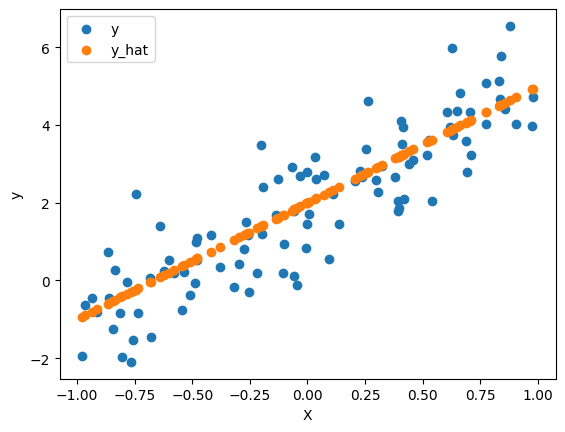

In [ ]:
size = 100

# Создаем тензор X размера (size, 2) заполненный единицами.
X = torch.ones(size, 2)

# Заполняем первый столбец X случайными числами равномерно распределенными от -1 до 1.
X[:, 0].uniform_(-1., 1)

# Создаем целевые значения y_hat как линейную комбинацию X[:, 0] (фактор 3) + 2.
y_hat = 3 * X[:, 0] + 2

# Создаем истинные значения y, добавив случайный шум к y_hat.
y = y_hat + torch.randn(size)

loss_animator = LossAnimator(X, y)

plt.scatter(loss_animator.X[:,0], loss_animator.y, label='y');
plt.scatter(loss_animator.X[:,0], y_hat, label='y_hat');
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

Посмотрим на ландшафт различных функций ошибок:

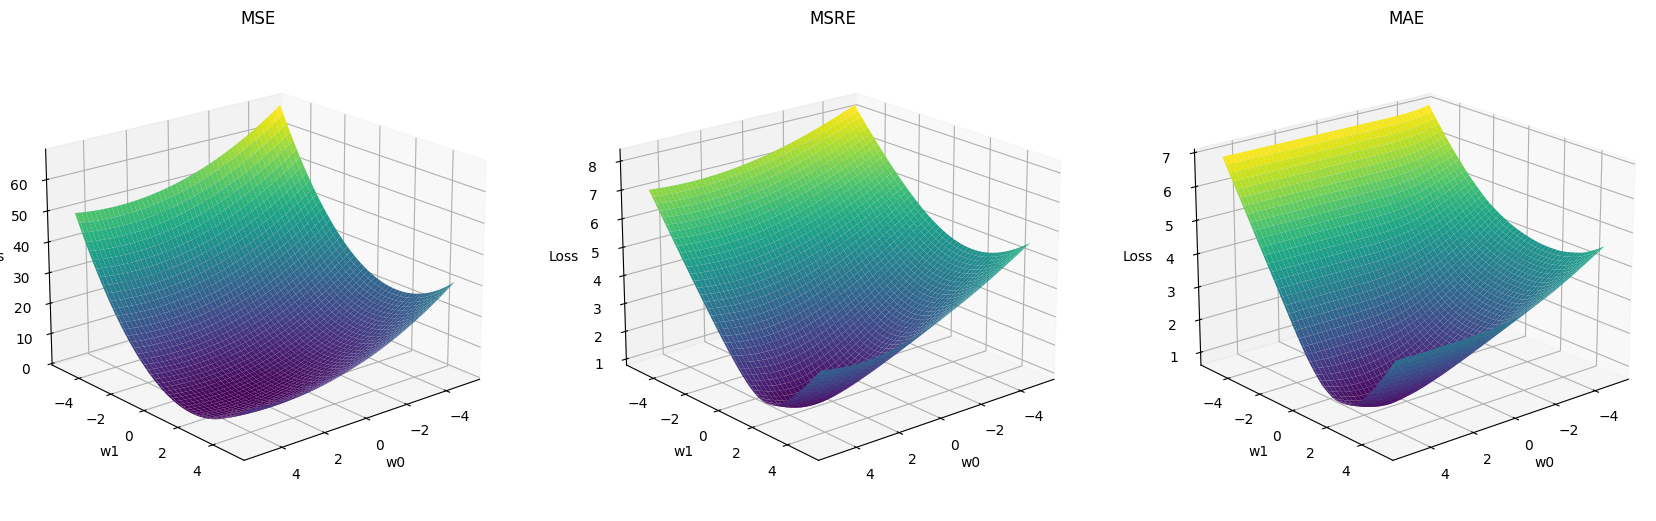

In [ ]:
weights = grid_samples()
loss_animator.plot_loss_funcs(weights, [mse, msre, mae], ['MSE', 'MSRE', 'MAE'])

Базовый класс оптимизаторов:

In [ ]:
class Optimizer:
    """
    Базовый класс для оптимизаторов.

    Attributes:
        params (list): Список параметров модели,
        которые необходимо оптимизировать.

    Notes:
        Этот класс является абстрактным и не должен использоваться напрямую.
        Он предназначен для создания конкретных оптимизаторов, которые
        наследуются от него и реализуют необходимые методы.
    """

    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        """
        Обнуляет градиенты всех параметров.

        Это важно делать перед каждым новым шагом оптимизации,
        так как PyTorch накапливает градиенты по умолчанию.
        """

        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def pre_step(self):
        """
        Метод для выполнения каких-либо действий перед шагом оптимизации.
        """
        pass

    def step(self):
        """
        Метод для выполнения шага оптимизации.
        """
        pass

    def update_param(self, p):
        """
        Абстрактный метод для обновления отдельного параметра.
        """
        raise NotImplementedError()

Функции для оптимизации и сравнения оптимизаторов:

In [ ]:
def optimize_function(fn: Callable,
                      optim: Optimizer,
                      optim_args: dict,
                      start_point,
                      num_iter = 50):
    """
    Оптимизирует функцию с помощью заданного алгоритма оптимизации.

    Args:
        fn (Callable): Функция, которую необходимо минимизировать. Принимает тензор весов
            и возвращает тензор потерь.
        optim (Optimizer): Класс оптимизатора, например, SGD.
        optim_args (dict): Словарь аргументов для конструктора оптимизатора.
            Например, {'lr': 0.01} для скорости обучения.
        start_point (list): Начальная точка для оптимизации.
        num_iter (int): Количество итераций оптимизации.

    Returns:
        tuple: Кортеж, содержащий:
            points (torch.Tensor): Тензор, содержащий историю изменения весов на каждой итерации,
              размерности (num_iter, *shape_of_start_point)
            losses (torch.Tensor): Тензор, содержащий историю значений потерь на каждой итерации,
              размерности (num_iter).
    """
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)
    points, losses = [], []

    for i in range(num_iter):

        if hasattr(optim, 'pre_step'):
            optim.pre_step()

        loss = fn(weigths)
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())

        loss.backward()
        optim.step()
        optim.zero_grad()

    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)

    return points, losses

In [ ]:
def compare_optimizers(loss_animator: LossAnimator,
                       fn: Callable,
                       optim_list: list,
                       start_point: list,
                       num_iter = 50,
                       step_skip = 1):
    """
    Сравнивает производительность нескольких алгоритмов оптимизации
    при минимизации заданной функции.

    Args:
        loss_animator (LossAnimator): Экземпляр LossAnimator,
        используемый для анимации процесса обучения.
        fn (Callable): Функция потерь, которую необходимо минимизировать.
        optim_list (list): Список кортежей, содержащих информацию о каждом оптимизаторе.
            Каждый кортеж должен иметь вид (name, optim, args), где:
                name (str): Имя оптимизатора.
                optim (type): Класс оптимизатора (например, SGD).
                args (dict): Словарь аргументов для конструктора оптимизатора.
        start_point (list): Начальная точка для оптимизации.
        num_iter (int): Количество итераций оптимизации.
        step_skip (int): Шаг пропуска при отрисовке кадров анимации.

    Returns:
        matplotlib.animation.FuncAnimation: Объект анимации Matplotlib.
    """

    data = {}
    loss_func = partial(loss_animator.loss_func, loss=fn)

    for name, optim, args in optim_list:
        points, losses = optimize_function(loss_func, optim,
                                           args, start_point, num_iter)
        data[name] = {'weights': points, 'losses': losses}

    return loss_animator.animate(num_iter, data, step_skip=step_skip)

Реализуйте метод градиентного спуска (1 балл):

$$\theta_t = \theta_{t-1} - \eta \sum_{i_1, ..., i_k} \nabla_{\theta} J_i(\theta_{t_1}) $$

In [ ]:
class SGD(Optimizer):
    """
    Реализация стохастического градиентного спуска.

    Attributes:
        lr (float): Скорость обучения, которая определяет величину
            шага обновления параметров.
    """
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.lr = lr

    def step(self):
        """
        Шаг оптимизатора.
        """
        for param in self.params:
            if param.grad is None:
                continue

            param.data -= self.lr * param.grad

In [ ]:
compare_optimizers(loss_animator, mse, [('SGD', SGD, {'lr': 1.5e-1})], start_point=[-20, -20], num_iter=100, step_skip = 10)

# Домашнее задание № 1
Реализовать методы оптимизации (*Momentum, NAG, Adagrad, Adadelta, Adam*), сравнить их между собой на предложенном примере и **написать вывод текстом**.

За каждый реализованный метод оптимизации - 1 балл.

ВАЖНО: баллы за методы оптимизации начисляются только в случае подбора параметров для каждого из них, а также наличия сравнения методов между собой и текстового вывода.

+ Мягкий дедлайн: `30.01.25 23:59`
+ Жесткий дедлайн: `06.02.25 23:59` (половина баллов)


После жесткого дедлайна задание не принимается.

In [ ]:
class Momentum(Optimizer):
    def __init__(self, params, lr=1e-2, momentum=0.9):
        super().__init__(params)
        self.lr = lr
        self.momentum = momentum
        self.v = [torch.zeros_like(param.data) for param in params]

    def step(self):
        for i, param in enumerate(self.params):
            if param.grad is not None:
                self.v[i] = self.momentum * self.v[i] - self.lr * param.grad
                param.data += self.v[i]


class NAG(Momentum):
    def step(self):
        for i, param in enumerate(self.params):
            if param.grad is not None:
                lookahead = param.data + self.momentum * self.v[i]
                param.grad = param.grad + self.momentum * self.v[i]
                self.v[i] = self.momentum * self.v[i] - self.lr * param.grad
                param.data += self.v[i]


class Adagrad(Optimizer):
    def __init__(self, params, lr=1e-2, epsilon=1e-8):
        super().__init__(params)
        self.lr = lr
        self.epsilon = epsilon
        self.sum_squared = [torch.zeros_like(param.data) for param in params]

    def step(self):
        for i, param in enumerate(self.params):
            if param.grad is not None:
                self.sum_squared[i] += param.grad**2
                ad_lr = self.lr / (torch.sqrt(self.sum_squared[i]) + self.epsilon)
                param.data -= ad_lr * param.grad


class Adadelta(Optimizer):
    def __init__(self, params, delta=0.9, epsilon=1e-8):
        super().__init__(params)
        self.delta = delta
        self.epsilon = epsilon
        self.acc_grads = [torch.zeros_like(param.data) for param in params]
        self.acc_updates = [torch.zeros_like(param.data) for param in params]

    def step(self):
        for i, param in enumerate(self.params):
            if param.grad is not None:
                self.acc_grads[i] = self.delta * self.acc_grads[i] + (1 - self.delta) * param.grad**2
                rms_grad = torch.sqrt(self.acc_grads[i] + self.epsilon)
                rms_update = torch.sqrt(self.acc_updates[i] + self.epsilon)
                update = -param.grad * (rms_update / rms_grad)
                self.acc_updates[i] = self.delta * self.acc_updates[i] + (1 - self.delta) * update**2
                param.data += update


class Adam(Optimizer):
    def __init__(self, params, lr=1e-3, beta1=0.9, beta2=0.999, epsilon=1e-8):
        super().__init__(params)
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = [torch.zeros_like(param.data) for param in params]
        self.v = [torch.zeros_like(param.data) for param in params]
        self.t = 0

    def step(self):
        self.t += 1
        for i, param in enumerate(self.params):
            if param.grad is not None:
                self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * param.grad
                self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * param.grad**2
                m_hat = self.m[i] / (1 - self.beta1**self.t)
                v_hat = self.v[i] / (1 - self.beta2**self.t)
                param.data -= self.lr * m_hat / (torch.sqrt(v_hat) + self.epsilon)


In [ ]:
optim_list = [
    ('Momentum', Momentum, {'lr': 0.1, 'momentum': 0.9}),
    ('NAG', NAG, {'lr': 0.1, 'momentum': 0.9}),
    ('Adagrad', Adagrad, {'lr': 3, 'epsilon': 1e-8}),
    ('Adadelta', Adadelta, {'delta': 0.99, 'epsilon': 1}),
    ('Adam', Adam, {'lr': 0.8, 'beta1': 0.8, 'beta2': 0.99, 'epsilon': 1e-8}),
]

compare_optimizers(
    loss_animator=loss_animator,
    fn=mse,
    optim_list=optim_list,
    start_point=[-20, -20],
    num_iter=100,
    step_skip=10
)


1. Adam демонстрирует быструю сходимость, особенно на начальных итерациях.
Это подтверждает его эффективность для задач с большим количеством параметров, где требуется баланс между скоростью сходимости и устойчивостью.
Вывод: Adam стабилен и быстро сходится, что делает его одним из лучших методов для общего применения.
2. Adadelta тоже быстро снижает значение функции потерь, особенно в первые 10 итераций. Однако темпы сходимости замедляются после начального этапа.
Вывод: Хорош для задач, где требуется адаптация шага обучения на основе градиентов.
3. Adagrad имеет быструю начальную сходимость, но её темпы значительно замедляются на более поздних итерациях. Это связано с тем, что Adagrad снижает шаг обучения из-за накопления градиентов.
Вывод: Подходит для задач с редкими признаками, но менее эффективен для долгосрочного обучения.
4. Momentum показывает колебания в процессе сходимости, что связано с инерцией обновлений. Однако он постепенно стабилизируется.
Вывод: Обеспечивает более быстрый выход из локальных минимумов, но может быть менее устойчивым.
5. NAG сходится быстрее, чем обычный Momentum, и показывает меньше колебаний благодаря учёту "взгляда вперёд".
Вывод: Более продвинутый вариант Momentum, обеспечивает лучшую сходимость.